### Data Mining on Hospital Dataset

This notebook looks at the Hospital dataset and builds a model to predict the onset of diabetes

### Imports

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import matplotlib.patches as mpatches
from IPython.display import HTML
from operator import itemgetter


import pandas as pd
import numpy as np


# pd.options.mode.chained_assignment = None 

### Helper functions

In [48]:
def print_bold(text):
    display(Markdown("**{}**".format(text)))
    
def print_color(text, color='red'):
    display(HTML("<text style=color:{}>{}</text>".format(color, text)))


def display_confusion_matrix(target_test, target_predict):
    print_bold('Confusion Matrix')
    y_actu = pd.Series(target_test, name='Actual')
    y_pred = pd.Series(target_predict, name='Predicted')
    print(pd.crosstab(y_actu, y_pred))
    
# Basic graph plotting utility
def plot_roc_curve(confusion_matrix_list, models, x_label, y_label, model_names=''):
    
    tpr_fpr_list = []
    
    for cm in confusion_matrix_list:
    
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        
        
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
    
        
        tpr_fpr_list.append((round(fpr, 2), round(tpr , 2)))
        
    tpr_fpr_list.sort(key=itemgetter(1))
    print(tpr_fpr_list)
    
    handles = []
    
    for model_name, model, color in models:
        patch = mpatches.Patch(color=color, label=model_name)
        handles.append(patch)
        
    fpr_list, tpr_list = zip(*tpr_fpr_list)
    
    fig, ax = plt.subplots()
    plt.plot(fpr_list, tpr_list, 'bs-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # ax.set_xlim([0,1])
    # ax.set_ylim([0,1])

    for idx, _   in enumerate(tpr_list):
        
        tpr = tpr_list[idx]
        fpr = fpr_list[idx]
#         plt.plot([fpr, fpr], [0, tpr], 'ks-') # vertical
#         plt.plot([0, fpr], [tpr, tpr], 'ks-') # horizontal
        plt.plot([fpr], [tpr], marker='o',  markersize=10, color=models[idx][2])
    plt.legend(handles=handles)
    plt.show()

### Read dataset

In [4]:
DATASET_NAME = 'dataset/diabetic_data.csv'
COLUMNS = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']
df = pd.read_csv(DATASET_NAME)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Find out missing values in the dataset

In [12]:
attributes = ['race', 'gender', 'age', 'medical_specialty','change','diabetesMed', 'readmitted']
for attr in attributes:
    print(attr,": ", sum(df[attr] == '?'))

race :  2273
gender :  0
age :  0
medical_specialty :  49949
change :  0
diabetesMed :  0
readmitted :  0


### Show statistics of the dataset

In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,1.652016e+08,1.026403e+08,12522.0,84961194.0,152388987.0,2.302709e+08,443867222.0
patient_nbr,101766.0,5.433040e+07,3.869636e+07,135.0,23413221.0,45505143.0,8.754595e+07,189502619.0
admission_type_id,101766.0,2.024006e+00,1.445403e+00,1.0,1.0,1.0,3.000000e+00,8.0
discharge_disposition_id,101766.0,3.715642e+00,5.280166e+00,1.0,1.0,1.0,4.000000e+00,28.0
admission_source_id,101766.0,5.754437e+00,4.064081e+00,1.0,1.0,7.0,7.000000e+00,25.0
time_in_hospital,101766.0,4.395987e+00,2.985108e+00,1.0,2.0,4.0,6.000000e+00,14.0
num_lab_procedures,101766.0,4.309564e+01,1.967436e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,101766.0,1.339730e+00,1.705807e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,101766.0,1.602184e+01,8.127566e+00,1.0,10.0,15.0,2.000000e+01,81.0
number_outpatient,101766.0,3.693572e-01,1.267265e+00,0.0,0.0,0.0,0.000000e+00,42.0


### Drop columns
Drop attributes like IDs and other attributes with 50% missing field

In [ ]:
bad_features = ['encounter_id', 'patient_nbr','weight', 'payer_code','admission_type_id','discharge_disposition_id','admission_source_id', 'num_lab_procedures', 'num_procedures','num_medications', 'number_outpatient', 'number_emergency','number_inpatient', 'diag_1', 'diag_2', 'diag_3','number_diagnoses','examide','citoglipton']
df.drop(bad_features, inplace=True, axis =1)

### Replace missing values

In [ ]:
df.loc[df['medical_specialty'] == "?", 'medical_specialty'] = 'Family/GeneralPractice'
df.loc[df['race'] == "?", 'race'] = 'Other'

df['medical_specialty'] = df['medical_specialty'].replace(['"?"', ''], 'General')
df['medical_specialty'] = df['medical_specialty'].replace(['"?"', ''], 'General')

### One Hot Encoding

In [20]:
dummy_columns = ['race', 'gender','age','metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
       'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'max_glu_serum','A1Cresult','readmitted', 'change','medical_specialty']
df_dummies = pd.get_dummies(df, columns=dummy_columns)
df_dummies.columns.values

array(['encounter_id', 'patient_nbr', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2',
       'diag_3', 'number_diagnoses', 'examide', 'citoglipton',
       'diabetesMed', 'race_?', 'race_AfricanAmerican', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_Female',
       'gender_Male', 'gender_Unknown/Invalid', 'age_[0-10)',
       'age_[10-20)', 'age_[20-30)', 'age_[30-40)', 'age_[40-50)',
       'age_[50-60)', 'age_[60-70)', 'age_[70-80)', 'age_[80-90)',
       'age_[90-100)', 'metformin_Down', 'metformin_No',
       'metformin_Steady', 'metformin_Up', 'repaglinide_Down',
       'repaglinide_No', 'repaglinide_Steady', 'repaglinide_Up',
       'nateglinide_Down', 'nateglinide_No', 'nateglinide_Steady',
       'nateglinide_Up',

In [28]:
df_target = df['Outcome']

# Drop the target variable from dataframe
df.drop('Outcome' , inplace = True, axis =1)
df_attr = df
df_attr.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


### Preprocessing
Replacing missing values with mean of the columns for selected attributes

In [29]:
imputer = Imputer(missing_values=0, strategy='mean', axis=0)

columns_to_impute = ["Insulin", "Glucose", "BloodPressure", "SkinThickness"]

for columns in columns_to_impute:
    df_attr[columns]=imputer.fit_transform(df[[columns]])
    
df_attr.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33


#### Split attribues for training and testing

In [30]:
attr_train, attr_test, target_train, target_test = train_test_split(df_attr , df_target)

### Models
Fit various models and check results

In [31]:
models = [('Decision Tree', DecisionTreeClassifier(max_depth= 5), 'red'), 
          ('Logistic Regression', LogisticRegression(), 'green'), 
          ('Random Forest', RandomForestClassifier(), 'yellow')]

predicted_results = []
for model_names, model, _ in models:
    model.fit(attr_train, target_train)
    target_predict = model.predict(attr_test)
    predicted_results.append(target_predict)

### Results
Show the results of various models

In [32]:
fpr_list = []
tpr_list = []
confusion_matrix_list = []

for idx, (model_name, model, _) in enumerate(models):
    print_color(model_name)
    print_bold('Accuracy Score')
    print(accuracy_score(target_test.values, predicted_results[idx]), end='\n\n')
    
    display_confusion_matrix(target_test.values, predicted_results[idx])
    cm = confusion_matrix(target_test, predicted_results[idx])
    confusion_matrix_list.append(cm)
    
    print_bold('Classification Report')
    print(classification_report(target_test, predicted_results[idx]))

**Accuracy Score**

0.755208333333



**Confusion Matrix**

Predicted    0   1
Actual            
0          101  19
1           28  44


**Classification Report**

             precision    recall  f1-score   support

          0       0.78      0.84      0.81       120
          1       0.70      0.61      0.65        72

avg / total       0.75      0.76      0.75       192



**Accuracy Score**

0.791666666667



**Confusion Matrix**

Predicted    0   1
Actual            
0          107  13
1           27  45


**Classification Report**

             precision    recall  f1-score   support

          0       0.80      0.89      0.84       120
          1       0.78      0.62      0.69        72

avg / total       0.79      0.79      0.79       192



**Accuracy Score**

0.755208333333



**Confusion Matrix**

Predicted    0   1
Actual            
0          104  16
1           31  41


**Classification Report**

             precision    recall  f1-score   support

          0       0.77      0.87      0.82       120
          1       0.72      0.57      0.64        72

avg / total       0.75      0.76      0.75       192



### Analysis

[(0.13, 0.56999999999999995), (0.16, 0.60999999999999999), (0.11, 0.62)]


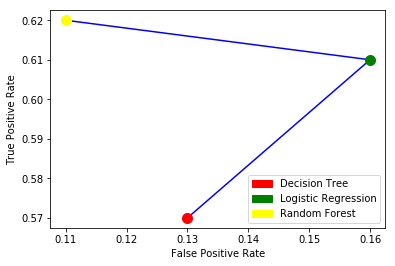

In [49]:
plot_roc_curve(confusion_matrix_list, models, 'False Positive Rate', 'True Positive Rate')